## This notbeook contains numerical attributes only

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.metrics import accuracy_score as score
from sklearn.impute import SimpleImputer
import seaborn as sns

In [34]:
file_1 = pd.read_csv('resources/2013-2014/demographic.csv')
file_2 = pd.read_csv('resources/2013-2014/examination.csv')
file_3 = pd.read_csv('resources/2013-2014/labs.csv')

df_1 = pd.DataFrame(file_1)
df_2 = pd.DataFrame(file_2)
df_3 = pd.DataFrame(file_3)

dataframes = [df_1,df_2,df_3]

merged=reduce(lambda left,right: pd.merge(left, right, on=['SEQN'], how='inner'), dataframes)
merged.dropna(how='all', axis=1)
merged.dropna(how='all', axis=0)

df = reduce(lambda left, right: pd.merge(left,right,on='SEQN'), dataframes)

print('columns: ' + str(len(df.columns.tolist())))
print('rows: ' + str(len(df.index)))

df = df.loc[:,['SEQN','RIDAGEYR','BPXSY2','BPXDI2','BMXWAIST','MGDCGSZ','BMXBMI','BMXARMC','BPXPLS','LBXGH']]

columns: 693
rows: 9813


In [5]:
df = df.rename(columns ={
    'SEQN': 'seqn',
    'RIAGENDR': 'gender',
    'RIDAGEYR': 'age',
    'RIDRETH3': 'ethnicity',
    'DMDEDUC3': 'education_child',
    'DMDEDUC2': 'education_adult',
    'INDHHIN2': 'household_income',
    'BMXWAIST': 'waist_circumference',
    'MGDCGSZ': 'grip',
    'BMXBMI': 'bmi',
    'BMXARMC': 'arm_circumference',
    'BPXPLS': 'pulse_60s',
    'BPXSY2': 'systolic',
    'BPXDI2': 'diastolic',
    'LBXGH': 'glycohemoglobin'
})

# WebMD definition of diabetes based on glycated hemoglobin levels.
# 3 classification labels

conditions = [
    (df['glycohemoglobin'] < 5.7),
    (df['glycohemoglobin'] >= 5.7) & (df['glycohemoglobin']<=6.4),
    (df['glycohemoglobin']>6.4)
]

diagnosis = [0,1,2]

df['diabetes'] = np.select(conditions, diagnosis)


# dropping rows where glycohemoglobin and pulse (if pulse is null --> syst/diast is null) is NaN 
df.dropna(axis=0, subset=['glycohemoglobin','pulse_60s'],inplace=True)
df = df.drop('glycohemoglobin', axis=1).drop('seqn', axis=1)

# Dropping age<19
df = df[df['age']>=18]
df.head()

,age,systolic,diastolic,waist_circumference,grip,bmi,arm_circumference,pulse_60s,diabetes
0,69,114.0,76.0,100.0,55.2,26.7,35.3,86.0,2
1,54,160.0,80.0,107.6,61.5,28.6,34.7,74.0,2
2,72,140.0,76.0,109.2,91.0,28.9,33.5,68.0,2
4,73,134.0,88.0,NaN,30.9,19.7,25.2,92.0,0
5,56,158.0,82.0,123.1,53.1,41.7,41.8,60.0,0


In [6]:
df.isna().sum()

age                      0
systolic               101
diastolic              101
waist_circumference    246
grip                   399
bmi                     57
arm_circumference      190
pulse_60s                0
diabetes                 0
dtype: int64

In [7]:
correlation = df.corr()
correlation["diabetes"].sort_values(ascending=False)

diabetes               1.000000
age                    0.420478
waist_circumference    0.329816
systolic               0.278478
bmi                    0.257546
arm_circumference      0.203870
pulse_60s              0.024771
diastolic              0.012824
grip                  -0.113390
Name: diabetes, dtype: float64

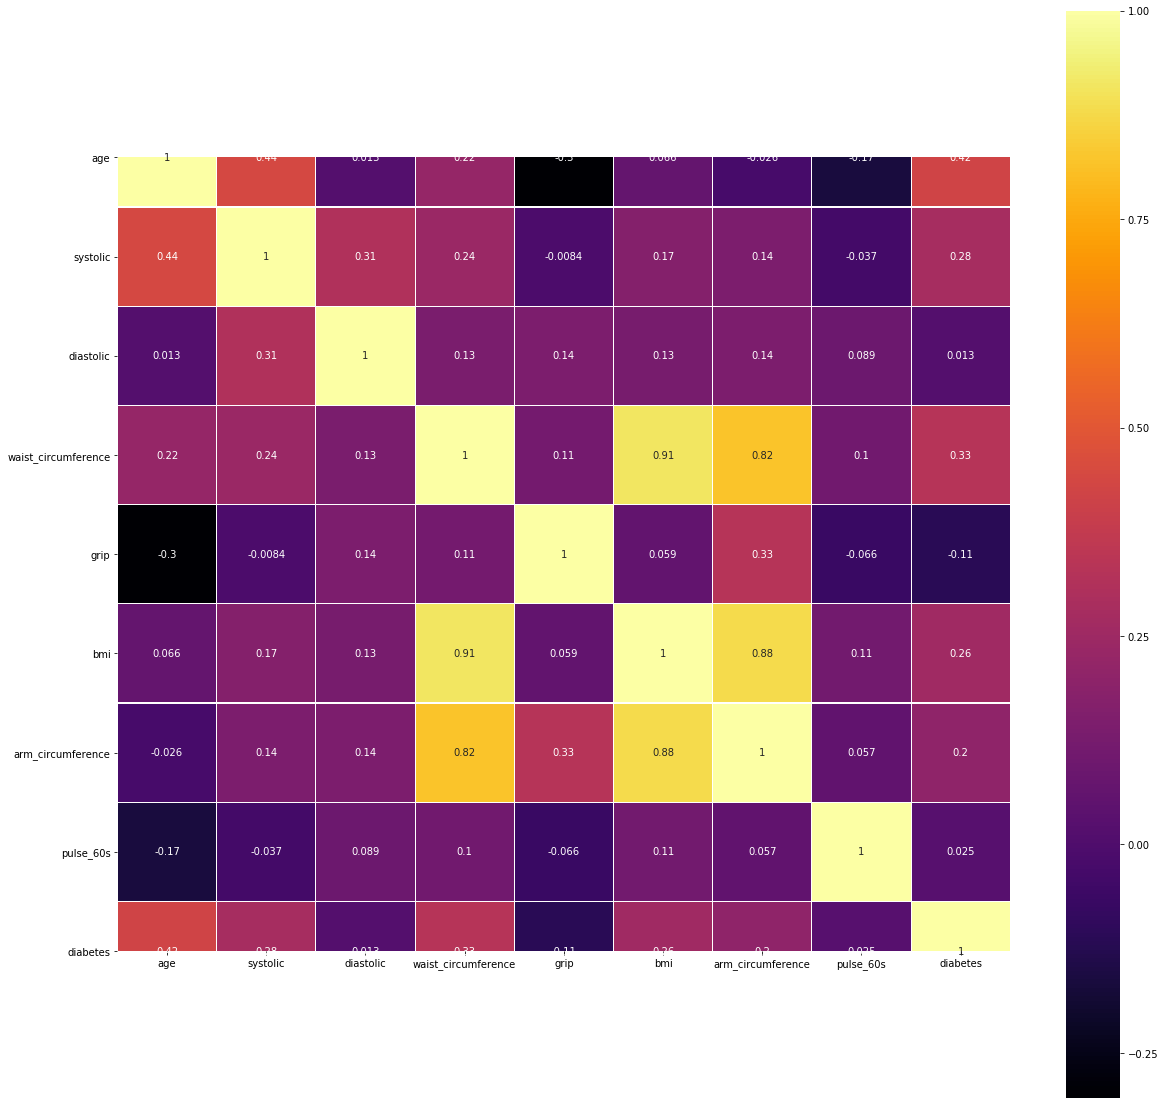

In [8]:
cm = plt.cm.inferno
plt.figure(figsize= (20,20))
sns.heatmap(df.astype(float).corr(), linewidths= 0.1, vmax=1, square=True, cmap=cm, annot=True)

In [9]:
# Proportions of labels in cleaned datset
print('Label Proportion in Clean Dataset')
print('non-diabetic: ' + str(df['diabetes'].value_counts()[0]/df['diabetes'].value_counts().sum()))
print('non-diabetic: ' + str(df['diabetes'].value_counts()[1]/df['diabetes'].value_counts().sum()))
print('non-diabetic: ' + str(df['diabetes'].value_counts()[2]/df['diabetes'].value_counts().sum()))

df.head(2)

Label Proportion in Clean Dataset
non-diabetic: 0.6410953935437069
non-diabetic: 0.254443235400798
non-diabetic: 0.1044613710554951


,age,systolic,diastolic,waist_circumference,grip,bmi,arm_circumference,pulse_60s,diabetes
0,69,114.0,76.0,100.0,55.2,26.7,35.3,86.0,2
1,54,160.0,80.0,107.6,61.5,28.6,34.7,74.0,2


In [10]:
from sklearn.preprocessing import Imputer

features = df.iloc[:,0:8].values
labels = df.iloc[:,8].values

imputer = Imputer(missing_values= 'NaN', strategy='median', axis=0)
imputer.fit(features[:, 1:7])
features[:, 1:7] = imputer.fit_transform(features[:, 1:7])

df_features = pd.DataFrame(features)

X = df_features.iloc[:,:].values
y = labels

df_features.isnull().sum()

/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

## Random Forest Classifier

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0,criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = (classifier.predict(X_test))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[620  80   7]
 [172  88  21]
 [ 51  54  10]]


0.6509519492293744

## PCA + Random Forest

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# PCA + RandomForest
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance

classifier = RandomForestClassifier(n_estimators=100, random_state=0,criterion='entropy')
classifier.fit(X_train, y_train)
y_pred = (classifier.predict(X_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[586  98  23]
 [172  74  35]
 [ 62  41  12]]


0.6092475067996374

## Logistic Regression

In [24]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[624  80   3]
 [186  91   4]
 [ 62  50   3]]


/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6509519492293744

## PCA + Logistic Regression

In [25]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance

classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[630  77   0]
 [209  72   0]
 [ 60  55   0]]


/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6364460562103355

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


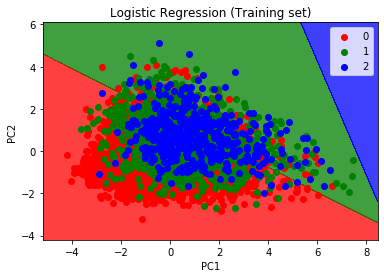

In [23]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

## Naive Bayes

In [26]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[583  92  32]
 [146 104  31]
 [ 35  46  34]]


0.6536718041704442

## Naive Bayes + PCA

In [27]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[654  52   1]
 [210  71   0]
 [ 70  43   2]]


0.6591115140525838

## SVM

In [28]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# from sklearn.linear_model import LogisticRegression
# pca = PCA(n_components = 2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[637  70   0]
 [184  97   0]
 [ 75  40   0]]


0.6654578422484134

## PCA + SVM

In [29]:
# PCA + Logistic Regression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, train_size=0.8)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

from sklearn.linear_model import LogisticRegression
pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_

# explained_variance
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
score(y_test, y_pred)

[[707   0   0]
 [281   0   0]
 [115   0   0]]


0.6409791477787852

## Neural Network

In [31]:
# NN

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#Importing Keras packages
import keras
from keras.models import Sequential
from keras.layers import Dense


#Initializing the ANN
classifier = Sequential()

#Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim=8,init='uniform',activation='relu',input_dim=8))

#Adding the second hidden layer
classifier.add(Dense(output_dim=8,init='uniform',activation='relu'))

#Adding the output layer
classifier.add(Dense(output_dim=1,init='uniform',activation='sigmoid'))

#Making predictions and evaluating the model
classifier.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#Fit ANN to training set
classifier.fit(X_train,y_train,epochs=100)

#Predicting the test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

Using TensorFlow backend.
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=8, units=8, kernel_initializer="uniform")`
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
/Users/mohamedmartino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`


Epoch 1/100
3859/3859 [==============================] - 0s 82us/step - loss: 0.6812 - accuracy: 0.6139
Epoch 2/100
3859/3859 [==============================] - 0s 30us/step - loss: 0.5664 - accuracy: 0.5942
Epoch 3/100
3859/3859 [==============================] - 0s 30us/step - loss: 0.4600 - accuracy: 0.6217
Epoch 4/100
3859/3859 [==============================] - 0s 29us/step - loss: 0.4258 - accuracy: 0.6318
Epoch 5/100
3859/3859 [==============================] - 0s 31us/step - loss: 0.4157 - accuracy: 0.6328
Epoch 6/100
3859/3859 [==============================] - 0s 31us/step - loss: 0.4082 - accuracy: 0.6357
Epoch 7/100
3859/3859 [==============================] - 0s 30us/step - loss: 0.4019 - accuracy: 0.6367
Epoch 8/100
3859/3859 [==============================] - 0s 30us/step - loss: 0.3972 - accuracy: 0.6349
Epoch 9/100
3859/3859 [==============================] - 0s 29us/step - loss: 0.3942 - accuracy: 0.6411
Epoch 10/100
3859/3859 [==============================] - 0s 30u

Epoch 79/100
3859/3859 [==============================] - 0s 38us/step - loss: -0.5013 - accuracy: 0.6455
Epoch 80/100
3859/3859 [==============================] - 0s 37us/step - loss: -0.5404 - accuracy: 0.6442
Epoch 81/100
3859/3859 [==============================] - 0s 30us/step - loss: -0.5919 - accuracy: 0.6445
Epoch 82/100
3859/3859 [==============================] - 0s 35us/step - loss: -0.6442 - accuracy: 0.6437
Epoch 83/100
3859/3859 [==============================] - 0s 29us/step - loss: -0.6952 - accuracy: 0.6437
Epoch 84/100
3859/3859 [==============================] - 0s 31us/step - loss: -0.7317 - accuracy: 0.6452
Epoch 85/100
3859/3859 [==============================] - 0s 31us/step - loss: -0.7925 - accuracy: 0.6445
Epoch 86/100
3859/3859 [==============================] - 0s 33us/step - loss: -0.8426 - accuracy: 0.6442
Epoch 87/100
3859/3859 [==============================] - 0s 32us/step - loss: -0.9050 - accuracy: 0.6452
Epoch 88/100
3859/3859 [======================

array([[771, 285,   0],
       [147, 289,   0],
       [ 22, 141,   0]])